# Toy Model Implementation

In [1]:
import os

import numpy as np
import pandas as pd

from scipy.stats import pearsonr
import torch

import plotnine as p9

sclembas_path = 'LEMBAS'
import sys
sys.path.insert(1, os.path.join(sclembas_path))
from LEMBAS.model.bionetwork import format_network, SignalingModel
from LEMBAS.model.train import train_signaling_model
import LEMBAS.utilities as utils
from LEMBAS import plotting, io

In [2]:
n_cores = 12
utils.set_cores(n_cores)

seed = 49
if seed:
    torch.use_deterministic_algorithms(True)
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
    utils.set_seeds(seed = seed)

device = "cuda" if torch.cuda.is_available() else "cpu"

## Load Input Data

In [3]:
# Prior knowledge signaling network
net = pd.read_csv('data/KEGGnet-Model.tsv', sep = '\t', index_col = False)

# Synthetic data input and output
x_data = pd.read_csv(os.path.join('data', 'synthetic_data_x.csv'), sep=',', low_memory=False, index_col=0)
x_cell = pd.read_csv(os.path.join('data', 'synthetic_data_xcell.csv'), sep=',', low_memory=False, index_col=0)
xtime_data = pd.read_csv(os.path.join('data', 'synthetic_data_xtime.csv'), sep=',', low_memory=False, index_col=0)
y_data = pd.read_csv(os.path.join('data', 'synthetic_data_y.csv'), sep=',', low_memory=False, index_col=0)

"""
# Keep only final time point - Steady state test
y_data.reset_index(inplace=True)
y_data['Condition'] = y_data['Condition_Time'].apply(lambda x: x.split('_')[0])
y_data['Time'] = y_data['Condition_Time'].apply(lambda x: x.split('_')[1])
y_data['Time'] = y_data['Time'].astype(int)
y_data_filtered = y_data[y_data['Time'] == 21]
y_data_filtered = y_data_filtered.drop(columns=['Time', 'Condition_Time'])
y_data_filtered.set_index('Condition', inplace=True)
y_data = y_data_filtered
"""

display(x_data.head())
display(x_cell.head())
display(xtime_data)
display(y_data.head())

,O14511,O14788,O14944,O43557,O75093,O75094,O75326,O94813,O96014,P00734,...,Q8NHW4,Q8WWG1,Q96A98,Q96B86,Q96S42,Q99075,Q9GZV9,Q9NPF7,Q9NSA1,Q9NT99
Drug_CL,,,,,,,,,,,,,,,,,,,,,
D_72_CL_0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D_72_CL_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D_72_CL_3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D_72_CL_4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D_72_CL_5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,CL_0,CL_1,CL_3,CL_4,CL_5,CL_6
Drug_CL,,,,,,
D_72_CL_0,1,0,0,0,0,0
D_72_CL_1,0,1,0,0,0,0
D_72_CL_3,0,0,1,0,0,0
D_72_CL_4,0,0,0,1,0,0
D_72_CL_5,0,0,0,0,1,0


,Drug_CL_Time,Time point
0,D_72_CL_0_0,0
1,D_72_CL_1_0,0
2,D_72_CL_3_0,0
3,D_72_CL_4_0,0
4,D_72_CL_5_0,0
...,...,...
379,DMSO_CL_1_50,50
380,DMSO_CL_3_50,50
381,DMSO_CL_4_50,50
382,DMSO_CL_5_50,50


,O00206,O14492,O14511,O14640,O14727,O14733,O14763,O14788,O14920,O14944,...,Q9UPT6,Q9UQC2,Q9Y243,Q9Y2X7,Q9Y4D1,Q9Y4H2,Q9Y4K3,Q9Y6K9,Q9Y6N7,Q9Y6Q6
Drug_CL_Time,,,,,,,,,,,,,,,,,,,,,
D_72_CL_0_0,-0.000056,0.021727,0.011471,-0.000305,5.414221e-07,-0.002145,-0.000230,-0.037347,-0.050841,0.009005,...,-0.002311,0.077535,-0.000521,0.191727,0.050499,-0.000382,0.025692,-0.001756,-0.000147,0.059051
D_72_CL_1_0,-0.000056,0.021727,0.011471,-0.000305,5.414221e-07,-0.002145,-0.000230,-0.018682,-0.027885,0.009005,...,-0.002311,0.077535,-0.000521,0.191727,0.050499,-0.000382,0.025692,-0.001756,-0.000147,-0.001717
D_72_CL_3_0,-0.000056,0.021727,0.011471,-0.000305,5.414221e-07,-0.002145,-0.003691,-0.000018,-0.004929,0.009005,...,-0.002311,0.077535,-0.020004,0.191727,0.050499,-0.000382,0.025692,-0.001756,-0.000147,0.059051
D_72_CL_4_0,-0.000056,0.021727,0.011471,-0.000305,5.414221e-07,-0.002145,-0.000230,-0.000018,-0.004929,0.009005,...,-0.002311,0.077535,-0.005163,0.191727,0.050499,-0.000382,0.025692,-0.001756,-0.000147,0.059051
D_72_CL_5_0,-0.000056,0.021727,0.011471,-0.000305,5.414221e-07,-0.002145,-0.000146,-0.000018,-0.004929,0.009005,...,-0.002311,0.077535,-0.002842,0.191727,0.050499,-0.000382,0.025692,-0.001756,-0.000147,0.059051


In [4]:
display(net.head())
#display(condition_input.head())
#display(ligand_input.head())
#display(data_out.head())
#display(tf_output.head())

,source,target,direction,stimulation,inhibition,sources,references
0,O15111,P19838,1,1,0,CancerCellMap;HPRD;HPRD-phos;HPRD_KEA;HPRD_MIM...,CancerCellMap:10469655;CancerCellMap:12482991;...
1,P45985,P45983,1,1,0,ACSN;ELM;HPRD;HPRD-phos;HPRD_KEA;HPRD_MIMP;Inn...,ACSN:11274345;ACSN:12624093;ACSN:12738796;ACSN...
2,Q13009,P63000,1,1,0,ACSN;Adhesome;BioGRID;CA1;HPRD;KEGG;Lit-BM-17;...,ACSN:11955434;ACSN:12829230;ACSN:15611338;ACSN...
3,P01112,Q13009,1,1,0,ACSN;Adhesome;HPRD;InnateDB;KEGG;SPIKE;Wang,ACSN:12134164;ACSN:7673236;ACSN:9069260;Adheso...
4,Q92851,P55957,1,1,0,HPRD;KEGG;SPIKE,HPRD:15772077;SPIKE:16186808


Let's see what the signaling network looks like:

In [5]:
stimulation_label = 'stimulation'
inhibition_label = 'inhibition'
weight_label = 'mode_of_action'
source_label = 'source'
target_label = 'target'

net[[source_label, target_label, stimulation_label, inhibition_label]].head()

,source,target,stimulation,inhibition
0,O15111,P19838,1,0
1,P45985,P45983,1,0
2,Q13009,P63000,1,0
3,P01112,Q13009,1,0
4,Q92851,P55957,1,0


Let's format it to fit with the necessary inputs to the SignalingModel:

In [6]:
net = format_network(net, weight_label = weight_label, stimulation_label = stimulation_label, inhibition_label = inhibition_label)
net[[source_label, target_label, weight_label, stimulation_label, inhibition_label]].head()

,source,target,mode_of_action,stimulation,inhibition
0,O15111,P19838,1.0,1,0
1,P45985,P45983,1.0,1,0
2,Q13009,P63000,1.0,1,0
3,P01112,Q13009,1.0,1,0
4,Q92851,P55957,1.0,1,0


## Define Parameters to Build and Train Model

In [7]:
# linear scaling of inputs/outputs
projection_amplitude_in = 3
projection_amplitude_out = 1.2
# other parameters
bionet_params = {'target_steps': 100, 'max_steps': 150, 'exp_factor':50, 'tolerance': 1e-5, 'leak':1e-2} # fed directly to model

# training parameters
lr_params = {'max_iter': 2000, 
             'learning_rate': 2e-3}
other_params = {'batch_size': 10, 'noise_level': 10, 'gradient_noise_level': 1e-9}
regularization_params = {'param_lambda_L2': 1e-6, 'moa_lambda_L1': 0.1, 'ligand_lambda_L2': 1e-5, 'uniform_lambda_L2': 1e-4, 
                   'uniform_max': 1/projection_amplitude_out, 'spectral_loss_factor': 1e-5}
spectral_radius_params = {'n_probes_spectral': 5, 'power_steps_spectral': 50, 'subset_n_spectral': 10}
target_spectral_radius = 0.8
hyper_params = {**lr_params, **other_params, **regularization_params, **spectral_radius_params}  # fed into training function | ** are used to combine multiple dictionaries -> it unpacks them

## Initialize Model
Next, let's initialize the model and format the inputs/outputs for running the model:

In [8]:
mod = SignalingModel(net = net,
                     X_in = x_data,
                     y_out = y_data, 
                     X_cell = x_cell,
                     projection_amplitude_in = projection_amplitude_in, projection_amplitude_out = projection_amplitude_out,
                     weight_label = weight_label, source_label = source_label, target_label = target_label,
                     bionet_params = bionet_params, 
                     dtype = torch.float32, device = device, seed = seed,
                     use_cell_line_network = True, hidden_layers = None)  # {1: 256, 2: 128}

#X_in = mod.df_to_tensor(mod.X_in)
#y_out = mod.df_to_tensor(mod.y_out)

In [9]:
mod.X_in.head()

,O14511,O14788,O14944,O43557,O75093,O75094,O75326,O94813,O96014,P00734,...,Q8NHW4,Q8WWG1,Q96A98,Q96B86,Q96S42,Q99075,Q9GZV9,Q9NPF7,Q9NSA1,Q9NT99
Drug_CL,,,,,,,,,,,,,,,,,,,,,
D_72_CL_0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D_72_CL_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D_72_CL_3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D_72_CL_4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D_72_CL_5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
mod.y_out.head()

,O00206,O14492,O14511,O14640,O14727,O14733,O14763,O14788,O14920,O14944,...,Q9UPT6,Q9UQC2,Q9Y243,Q9Y2X7,Q9Y4D1,Q9Y4H2,Q9Y4K3,Q9Y6K9,Q9Y6N7,Q9Y6Q6
Drug_CL_Time,,,,,,,,,,,,,,,,,,,,,
D_72_CL_0_0,-0.000056,0.021727,0.011471,-0.000305,5.414221e-07,-0.002145,-0.000230,-0.037347,-0.050841,0.009005,...,-0.002311,0.077535,-0.000521,0.191727,0.050499,-0.000382,0.025692,-0.001756,-0.000147,0.059051
D_72_CL_1_0,-0.000056,0.021727,0.011471,-0.000305,5.414221e-07,-0.002145,-0.000230,-0.018682,-0.027885,0.009005,...,-0.002311,0.077535,-0.000521,0.191727,0.050499,-0.000382,0.025692,-0.001756,-0.000147,-0.001717
D_72_CL_3_0,-0.000056,0.021727,0.011471,-0.000305,5.414221e-07,-0.002145,-0.003691,-0.000018,-0.004929,0.009005,...,-0.002311,0.077535,-0.020004,0.191727,0.050499,-0.000382,0.025692,-0.001756,-0.000147,0.059051
D_72_CL_4_0,-0.000056,0.021727,0.011471,-0.000305,5.414221e-07,-0.002145,-0.000230,-0.000018,-0.004929,0.009005,...,-0.002311,0.077535,-0.005163,0.191727,0.050499,-0.000382,0.025692,-0.001756,-0.000147,0.059051
D_72_CL_5_0,-0.000056,0.021727,0.011471,-0.000305,5.414221e-07,-0.002145,-0.000146,-0.000018,-0.004929,0.009005,...,-0.002311,0.077535,-0.002842,0.191727,0.050499,-0.000382,0.025692,-0.001756,-0.000147,0.059051


A forward pass looks like this:

In [11]:
# X_in = mod.df_to_tensor(mod.X_in) # ligand inputs
# X_full = mod.input_layer(X_in) # ligand inputs in signaling network
# Y_full = mod.signaling_network(X_full) # signaling network weights
# Y_hat = mod.output_layer(Y_full) # TF outputs of signaling network

## Train Model

In [12]:
# model setup
mod.input_layer.weights.requires_grad = False # don't learn scaling factors for the ligand input concentrations
mod.signaling_network.prescale_weights(target_radius = target_spectral_radius) # spectral radius

# loss and optimizer
loss_fn = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam

# training loop
mod, cur_loss, cur_eig, mean_loss, stats, X_train, X_test, X_train_index, y_train, y_test, y_train_index, X_cell_train, X_cell_test, missing_node_indexes, time_map = train_signaling_model(
    mod, net, optimizer, loss_fn, reset_epoch = 200, hyper_params = hyper_params, train_split_frac = {'train': 0.7, 'test': 0.3, 'validation': None}, train_seed = seed, 
    verbose = True, split_by = 'condition') 

# store results
io.write_pickled_object(stats, os.path.join('data', 'training_stats_cond.pickle'))
torch.save(obj=mod.state_dict(), f=os.path.join('data', 'mac_state_dict_cond.pth'))

i=0, l=0.10643, s=0.463, r=0.00020, v=0
tensor([ 0., 14., 28., 40., 50., 58., 66., 72.])
i=250, l=0.01930, s=0.518, r=0.00046, v=0
tensor([ 0.,  8., 18., 28., 38., 46., 54., 60.])
i=500, l=0.00436, s=0.792, r=0.00110, v=0
tensor([ 0.,  0.,  4.,  6., 12., 18., 24., 30.])
i=750, l=0.00111, s=0.638, r=0.00174, v=0
tensor([ 0.,  2.,  2.,  4.,  6., 10., 14., 20.])
i=1000, l=0.00076, s=0.676, r=0.00200, v=0
tensor([ 0.,  2.,  2.,  4.,  6., 10., 16., 22.])
i=1250, l=0.00053, s=0.644, r=0.00164, v=1
tensor([ 0.,  2.,  2.,  2.,  6., 10., 16., 22.])
i=1500, l=0.00031, s=0.648, r=0.00083, v=0
tensor([ 0.,  2.,  2.,  2.,  6., 10., 16., 24.])
i=1750, l=0.00019, s=0.664, r=0.00013, v=0
tensor([ 0.,  2.,  2.,  2.,  4., 10., 18., 24.])
Training ran in: 15 min 3.42 sec


## Predict Using Model

In [13]:
mod.load_state_dict(torch.load(os.path.join('data', 'mac_state_dict_cond.pth'), map_location=torch.device('cpu')))
stats = io.read_pickled_object(os.path.join('data', 'training_stats_cond.pickle'))

C:\Users\kanto\AppData\Local\Temp\ipykernel_26516\560733483.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [14]:
#X_in = mod.df_to_tensor(mod.X_in)
#X_cell = mod.df_to_tensor(mod.X_cell)
mod.eval()
Y_hat, Y_full, Y_fullFull = mod(X_test, X_cell_test)

## Visualize

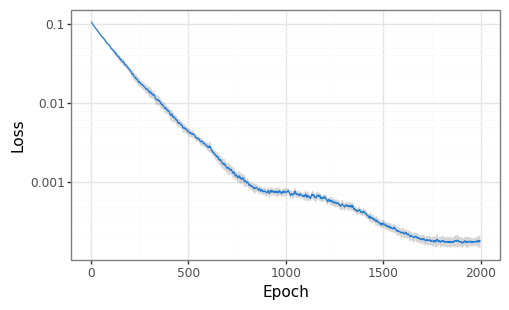

In [15]:
loss_smooth = utils.get_moving_average(values = stats['loss_mean'], n_steps = 5)
loss_sigma_smooth = utils.get_moving_average(values = stats['loss_sigma'], n_steps = 10)
epochs = np.array(range(stats['loss_mean'].shape[0]))

p1A = plotting.shade_plot(X = epochs, Y = loss_smooth, sigma = loss_sigma_smooth, x_label = 'Epoch', y_label = 'Loss')
p1A += p9.scale_y_log10()
#p1A += p9.geom_hline(yintercept = mean_loss.item(), linetype="dashed", color="black")
p1A.draw()

As well as how the learning rate was adjusted across training:

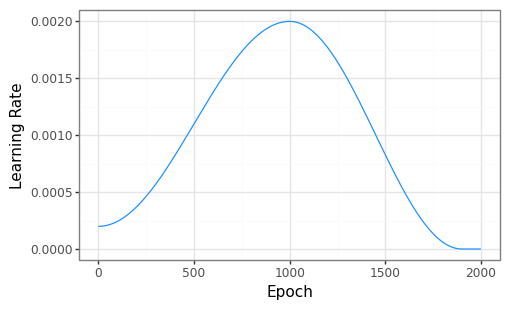

In [16]:
viz_df = pd.DataFrame(data = {'Epoch': epochs, 'lr': stats['learning_rate']})
width, height = 5, 3
p1B = (
    p9.ggplot(viz_df, p9.aes(x='Epoch', y = 'lr')) +
    p9.geom_line(color = '#1E90FF') +
    p9.theme_bw() + 
    p9.theme(figure_size=(width, height)) +
    p9.ylab('Learning Rate')
)
p1B.draw()

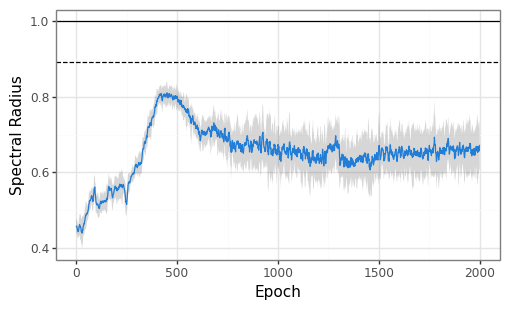

In [17]:
eig_smooth = utils.get_moving_average(stats['eig_mean'], 5)
eig_sigma_smooth = utils.get_moving_average(stats['eig_sigma'], 5)

p1C = plotting.shade_plot(X = epochs, Y = eig_smooth, sigma = eig_sigma_smooth, x_label = 'Epoch', y_label = 'Spectral Radius')
p1C += p9.geom_hline(yintercept = mod.signaling_network.training_params['spectral_target'], linetype="dashed", color="black")
p1C += p9.geom_hline(yintercept = 1, color="black")
p1C.draw()

torch.Size([120, 409]) torch.Size([120, 409])


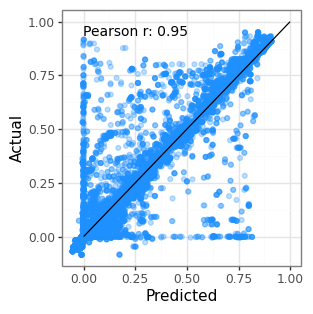

In [18]:
#y_out = mod.df_to_tensor(mod.y_out)
y_index = mod.y_out.index.tolist()
y_out = y_test
#time_points = [int(idx.rsplit('_', 1)[-1]) for idx in y_index]
#seen = set()
#unique_time_points = [x for x in time_points if not (x in seen or seen.add(x))]
#Y_subsampled = Y_fullFull[:, unique_time_points, :]
Y_subsampled = Y_fullFull[:, time_map.long().tolist(), :]
Y_subsampled = Y_subsampled.permute(1, 0, 2)
Y_subsampled = torch.flatten(Y_subsampled, start_dim=0, end_dim=1)
print(Y_subsampled.shape, y_out.shape)

# Subsample Y_subsampled 3rd dimension (gene nodes) to calculate loss
node_labels = sorted(pd.concat([net['source'], net['target']]).unique())
mask = torch.tensor([i not in missing_node_indexes for i in range(len(node_labels))])
Y_subsampled = Y_subsampled[:, mask]

y_pred = Y_subsampled.detach().flatten().cpu().numpy()
y_actual = y_out.detach().flatten().cpu().numpy()

# Mask NaNs
mask = ~np.isnan(y_pred) & ~np.isnan(y_actual)
y_pred_filtered = y_pred[mask]
y_actual_filtered = y_actual[mask]

pr, _ = pearsonr(y_pred_filtered, y_actual_filtered)

viz_df = pd.DataFrame(data = {'Predicted': y_pred_filtered, 'Actual': y_actual_filtered})
width, height = 3, 3
p2 = (
    p9.ggplot() +
    p9.geom_point(data = viz_df, mapping = p9.aes(x='Predicted', y = 'Actual'), color = '#1E90FF', alpha = 0.3) +
    p9.geom_line(data = pd.DataFrame(data = {'x': [0,1], 'y': [0, 1]}), mapping = p9.aes(x='x', y = 'y'), color = 'black') +
    p9.theme_bw() + 
    p9.theme(figure_size=(width, height)) +
    p9.annotate(geom = 'text', x=0.25, y = 0.95, label = 'Pearson r: {:.2f}'.format(pr), size = 10)
)
p2.draw()

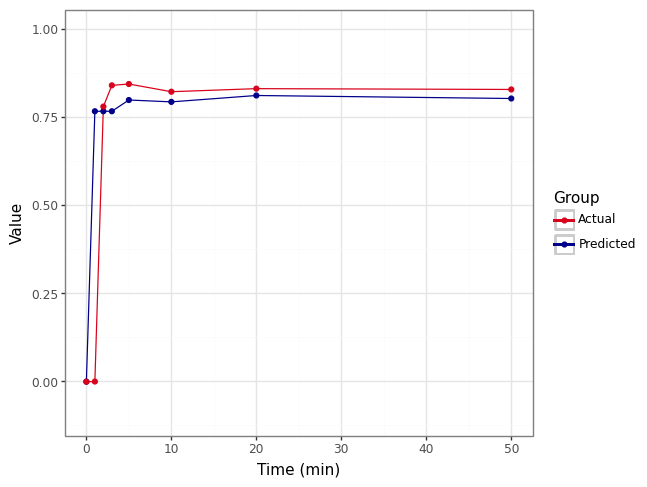

In [19]:
#print(time_map.long().tolist())
x_values = [0, 1, 2, 3, 5, 10, 20, 50]  #list(range(150))  [0, 2 , 5, 12, 28, 64, 149]  [0, 3, 6, 9, 12, 15, 18]  [0, 1, 2, 3, 5, 10, 20, 50]
Y_plot = Y_fullFull
#Y_plot = Y_fullFull[:, x_values, :]

Y_plot = Y_plot[:, time_map.long().tolist(), :]
mask = torch.tensor([i not in missing_node_indexes for i in range(len(node_labels))])
Y_plot = Y_plot[:, :, mask]

# Identify condition index
y_data_filtered = y_data.loc[~y_data.index.isin(y_train_index)]
y_data_filtered = y_data_filtered.reset_index()
y_data_filtered['Time'] = y_data_filtered['Drug_CL_Time'].str.split('_').str[-1].astype(int)
y_data_filtered['Drug_CL'] = y_data_filtered['Drug_CL_Time'].str.rsplit('_', n=1).str[0]
y_data_filtered = y_data_filtered.drop(columns=['Drug_CL_Time'])            
y_data_filtered = y_data_filtered.sort_values(by=['Time', 'Drug_CL'])
x_data_filtered = x_data.loc[~x_data.index.isin(X_train_index)]
x_data_filtered = x_data_filtered.loc[y_data_filtered['Drug_CL'].unique()]
y_data_filtered['Drug_CL_Time'] = y_data_filtered['Drug_CL'] + '_' + y_data_filtered['Time'].astype(str)
y_data_filtered = y_data_filtered.set_index('Drug_CL_Time').drop(columns=['Drug_CL', 'Time'])

cond = 'D_15_CL_5'
d1_indices = []
for x in x_values:
    cond_time = cond + '_' + str(x)
    cond_idx = y_data_filtered.index.get_loc(cond_time)
    d1_indices.append(cond_idx)

cond_idx = x_data_filtered.index.get_loc(cond)
gene_idx = y_data_filtered.columns.get_loc('Q15796')
y_values = Y_plot[cond_idx, :, gene_idx].detach().cpu().numpy()

df_1 = pd.DataFrame({
    'X': x_values,
    'Y': y_values
})

y_values_2 = y_test[d1_indices, gene_idx].detach().cpu().numpy()
df_2 = pd.DataFrame({
    'X': x_values,
    'Y': y_values_2,
    'Group': 'Actual'
})

df_1['Group'] = 'Predicted'  # Add label for the first dataset
df_combined = pd.concat([df_1, df_2], ignore_index=True)

# Plot using plotnine
plot = (p9.ggplot(df_combined, p9.aes(x='X', y='Y', color='Group')) +
        p9.geom_line() +
        p9.geom_point() +
        p9.theme_bw() + 
        p9.labs(x='Time (min)', y='Value') +
        p9.scale_color_manual(values={'Predicted': 'darkblue', 'Actual': '#d8031c'}) +
        p9.ylim(-0.1, 1))
plot.draw()

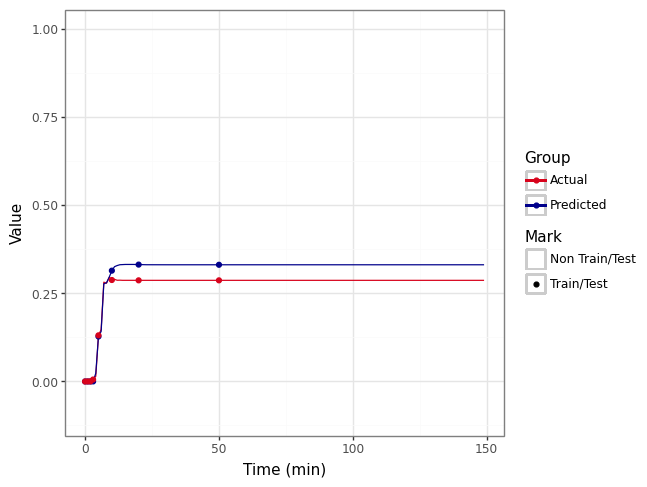

In [20]:
cond_idx = 10
gene_idx = 310
Y_plot = Y_fullFull
y_values = Y_plot[cond_idx, :, gene_idx].detach().cpu().numpy()

df_1 = pd.DataFrame({
    'X': range(150),
    'Y': y_values
})

y_data_full = pd.read_csv(os.path.join('data', 'synthetic_data_y_full.csv'), sep=',', low_memory=False, index_col=0)
y_train_drug_cl = [idx.rsplit('_', 1)[0] for idx in y_train_index]

y_data_full = y_data_full.reset_index()
y_data_full['Time'] = y_data_full['Drug_CL_Time'].str.split('_').str[-1].astype(int)
y_data_full['Drug_CL'] = y_data_full['Drug_CL_Time'].str.rsplit('_', n=1).str[0]

# Filter y_data_full to keep only the rows with Drug_CL that are not in y_train_drug_cl
y_data_full_filtered = y_data_full[~y_data_full['Drug_CL'].isin(y_train_drug_cl)].copy()
y_data_full_filtered['Drug_CL_Time'] = y_data_full_filtered['Drug_CL'] + '_' + y_data_full_filtered['Time'].astype(str)
y_data_full_filtered = y_data_full_filtered.sort_values(by=['Time', 'Drug_CL'])
y_data_full_filtered = y_data_full_filtered.set_index('Drug_CL_Time').drop(columns=['Drug_CL', 'Time'])
y_data_full_tensor = mod.df_to_tensor(y_data_full_filtered)

d1_indices = [cond_idx + x * y_data_full_tensor.shape[0]/len(range(150)) for x in range(150)]
y_values_2 = y_data_full_tensor[d1_indices, gene_idx].detach().cpu().numpy()

df_2 = pd.DataFrame({
    'X': range(150),
    'Y': y_values_2,
    'Group': 'Actual'
})

df_1['Group'] = 'Predicted'  # Add label for the first dataset
df_combined = pd.concat([df_1, df_2], ignore_index=True)

df_combined['Mark'] = df_combined['X'].apply(lambda x: 'Train/Test' if x in x_values else 'Non Train/Test')

# Plot using plotnine
plot = (p9.ggplot(df_combined, p9.aes(x='X', y='Y', color='Group')) +
        p9.geom_line() +
        p9.geom_point(p9.aes(shape='Mark')) +
        p9.theme_bw() + 
        p9.labs(x='Time (min)', y='Value') +
        p9.scale_color_manual(values={'Predicted': 'darkblue', 'Actual': '#d8031c'}) +
        p9.scale_shape_manual(values={'Train/Test': 'o', 'Non Train/Test': ''}) +
        p9.ylim(-0.1, 1))
plot.draw()